In [9]:
!pip install transformers nlp

     |████████████████████████████████| 778kB 6.7MB/s 
     |████████████████████████████████| 1.7MB 18.0MB/s 
     |████████████████████████████████| 890kB 40.2MB/s 
     |████████████████████████████████| 3.0MB 39.5MB/s 
     |████████████████████████████████| 1.1MB 41.9MB/s 
     |████████████████████████████████| 245kB 43.4MB/s 
     |████████████████████████████████| 17.2MB 191kB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=29193677595a39cf24eed627b9ab9f1baa33e633eb50dc31429c12a24f4bfa98
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [10]:
import os
import random
import collections

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, AdamW
import nlp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

In [12]:

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla K80


In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TRAIN_FILE = "./input/train.csv"
TEST_FILE = "./input/test.csv"
MODELS_DIR = "./models/"
MODEL_NAME = 'bert-base-uncased'
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 128
NUM_CLASSES = 4
EPOCHS = 5
NUM_SPLITS = 5

In [14]:
def make_folded_df(csv_file, num_splits=5):
    df = pd.read_csv(csv_file)
    df["jobflag"] = df["jobflag"] - 1
    df["kfold"] = np.nan
    df = df.rename(columns={'jobflag': 'labels'})
    label = df["labels"].tolist()

    skfold = StratifiedKFold(num_splits, shuffle=True, random_state=SEED)
    for fold, (_, valid_indexes) in enumerate(skfold.split(range(len(label)), label)):
        for i in valid_indexes:
            df.iat[i,3] = fold
    return df

In [15]:
def make_dataset(df, tokenizer, device):
    dataset = nlp.Dataset.from_pandas(df)
    dataset = dataset.map(
        lambda example: tokenizer(example["description"],
                                  padding="max_length",
                                  truncation=True,
                                  max_length=128))
    dataset.set_format(type='torch', 
                       columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], 
                       device=device)
    return dataset

In [16]:
class Classifier(nn.Module):
    def __init__(self, model_name, num_classes=4):
        super().__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_classes)
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.zeros_(self.linear.bias)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output, _ = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.linear(output)
        return output

In [17]:
def train_fn(dataloader, model, criterion, optimizer, scheduler, device, epoch):

    model.train()
    total_loss = 0
    total_corrects = 0
    all_labels = []
    all_preds = []

    progress = tqdm(dataloader, total=len(dataloader))

    for i, batch in enumerate(progress):
        progress.set_description(f"<Train> Epoch{epoch+1}")

        attention_mask, input_ids, labels, token_type_ids = batch.values()
        del batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask, token_type_ids)
        del input_ids, attention_mask, token_type_ids
        loss = criterion(outputs, labels)  # 損失を計算
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        del outputs

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        del loss
        total_corrects += torch.sum(preds == labels)

        all_labels += labels.tolist()
        all_preds += preds.tolist()
        del labels, preds

        progress.set_postfix(loss=total_loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

    train_loss = total_loss / len(dataloader)
    train_acc = total_corrects.double().cpu().detach().numpy() / len(dataloader.dataset)
    train_f1 = f1_score(all_labels, all_preds, average="macro")

    return train_loss, train_acc, train_f1

In [18]:
def eval_fn(dataloader, model, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        progress = tqdm(dataloader, total=len(dataloader))
        
        for i, batch in enumerate(progress):
            progress.set_description(f"<Valid> Epoch{epoch+1}")

            attention_mask, input_ids, labels, token_type_ids = batch.values()
            del batch

            outputs = model(input_ids, attention_mask, token_type_ids)
            del input_ids, attention_mask, token_type_ids
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            del outputs

            total_loss += loss.item()
            del loss
            total_corrects += torch.sum(preds == labels)

            all_labels += labels.tolist()
            all_preds += preds.tolist()
            del labels, preds

            progress.set_postfix(loss=total_loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

    valid_loss = total_loss / len(dataloader)
    valid_acc = total_corrects.double().cpu().detach().numpy() / len(dataloader.dataset)

    valid_f1 = f1_score(all_labels, all_preds, average="macro")

    return valid_loss, valid_acc, valid_f1

In [19]:
def plot_training(train_losses, train_accs, train_f1s,
                  valid_losses, valid_accs, valid_f1s,
                  epoch, fold):
    
    loss_df = pd.DataFrame({"Train":train_losses,
                            "Valid":valid_losses},
                        index=range(1, epoch+2))
    loss_ax = sns.lineplot(data=loss_df).get_figure()
    loss_ax.savefig(f"./figures/loss_plot_fold={fold}.png", dpi=300)
    loss_ax.clf()

    acc_df = pd.DataFrame({"Train":train_accs,
                           "Valid":valid_accs},
                          index=range(1, epoch+2))
    acc_ax = sns.lineplot(data=acc_df).get_figure()
    acc_ax.savefig(f"./figures/acc_plot_fold={fold}.png", dpi=300)
    acc_ax.clf()

    f1_df = pd.DataFrame({"Train":train_f1s,
                          "Valid":valid_f1s},
                         index=range(1, epoch+2))
    f1_ax = sns.lineplot(data=f1_df).get_figure()
    f1_ax.savefig(f"./figures/f1_plot_fold={fold}.png", dpi=300)
    f1_ax.clf()

In [32]:
def trainer(fold, df):

    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    train_dataset = make_dataset(train_df, tokenizer, DEVICE)
    valid_dataset = make_dataset(valid_df, tokenizer, DEVICE)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
    )
    valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False
    )

    model = Classifier(MODEL_NAME, num_classes=NUM_CLASSES)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100000, gamma=1.0)
    # ダミーのスケジューラー

    train_losses = []
    train_accs = []
    train_f1s = []
    valid_losses = []
    valid_accs = []
    valid_f1s = []

    best_loss = np.inf
    best_acc = 0
    best_f1 = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1 = train_fn(train_dataloader, model, criterion, optimizer, scheduler, DEVICE, epoch)
        valid_loss, valid_acc, valid_f1 = eval_fn(valid_dataloader, model, criterion, DEVICE, epoch)
        print(f"Loss: {valid_loss}  Acc: {valid_acc}  f1: {valid_f1}  ", end="")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        valid_f1s.append(valid_f1)

        plot_training(train_losses, train_accs, train_f1s,
                      valid_losses, valid_accs, valid_f1s,
                      epoch, fold)
        
        best_loss = valid_loss if valid_loss < best_loss else best_loss
        besl_acc = valid_acc if valid_acc > best_acc else best_acc
        if valid_f1 > best_f1:
            best_f1 = valid_f1
            print("model saving!", end="")
            torch.save(model.state_dict(), MODELS_DIR + f"best_{MODEL_NAME}_{fold}.pth")
        print("\n")

    return best_f1, [train_losses, train_accs, valid_losses, valid_accs, train_f1s, valid_f1s]

In [34]:
NUM_SPLITS = 2
df = make_folded_df(TRAIN_FILE, NUM_SPLITS)
f1_scores = []
for fold in range(NUM_SPLITS):
    print(f"fold {fold}", "="*80)
    f1, hist = trainer(fold, df)
    f1_scores.append(f1)
    print(f"<fold={fold}> best score: {f1}\n")

fold 0 ================================================================================



Loss: 1.0250972757736843  Acc: 0.5866302864938608  f1: 0.39828903198656296  model saving!




Loss: 0.8753999074300131  Acc: 0.6739427012278308  f1: 0.5257745599850863  model saving!




Loss: 0.8809006114800771  Acc: 0.6705320600272852  f1: 0.5717465264867513  model saving!




Loss: 0.9875861406326294  Acc: 0.6630286493860846  f1: 0.5747425062453633  model saving!




Loss: 1.0711363007624943  Acc: 0.6630286493860846  f1: 0.5828123518876058  model saving!

<fold=0> best score: 0.5828123518876058

fold 1 ================================================================================



Loss: 0.994121049841245  Acc: 0.5815699658703072  f1: 0.3617808343168093  model saving!




Loss: 0.9170736620823542  Acc: 0.6450511945392492  f1: 0.5305660605747412  model saving!




Loss: 0.9249093433221182  Acc: 0.653924914675768  f1: 0.5786766798325629  model saving!




Loss: 1.0220119804143906  Acc: 0.6450511945392492  f1: 0.5788873939987468  model saving!




Loss: 1.1465357045332591  Acc: 0.6368600682593857  f1: 0.5757005073165324  

<fold=1> best score: 0.5788873939987468



<Figure size 432x288 with 0 Axes>

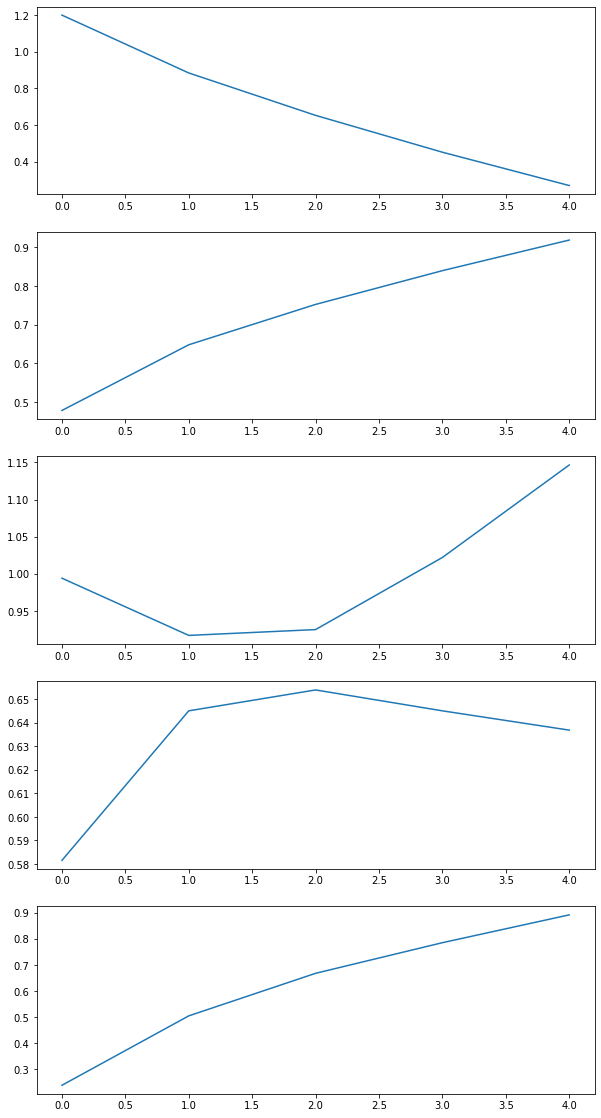

In [38]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
for i in range(5):
  axs[i].plot(range(5), hist[i])
plt.show()


In [22]:
cv = sum(f1_scores) / len(f1_scores)
print(f"CV: {cv}")

CV: 0.6222416806820212


In [23]:
lines = ""
for i, f1 in enumerate(f1_scores):
    line = f"fold={i}: {f1}\n"
    lines += line
lines += f"CV    : {cv}"
with open(f"./result/{MODEL_NAME}_result.txt", mode='w') as f:
    f.write(lines)

In [24]:
models = []
for fold in range(NUM_SPLITS):
    model = Classifier(MODEL_NAME)
    model.load_state_dict(torch.load(MODELS_DIR + f"best_{MODEL_NAME}_{fold}.pth"))
    model.to(DEVICE)
    model.eval()
    models.append(model)

In [25]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_df = pd.read_csv(TEST_FILE)
test_df["labels"] = -1
test_dataset = make_dataset(test_df, tokenizer, DEVICE)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [26]:
with torch.no_grad():
    progress = tqdm(test_dataloader, total=len(test_dataloader))
    final_output = []

    for batch in progress:
        progress.set_description("<Test>")

        attention_mask, input_ids, labels, token_type_ids = batch.values()

        outputs = []
        for model in models:
            output = model(input_ids, attention_mask, token_type_ids)
            outputs.append(output)

        outputs = sum(outputs) / len(outputs)
        outputs = torch.softmax(outputs, dim=1).cpu().detach().tolist()
        outputs = np.argmax(outputs, axis=1)

        final_output.extend(outputs)

In [27]:
submit = pd.read_csv("./input/submit_sample.csv", names=["id", "labels"])
submit["labels"] = final_output
submit["labels"] = submit["labels"] + 1
try:
    submit.to_csv("./output/submission_cv{}.csv".format(str(cv).replace(".", "")[:10]), index=False, header=False)
except NameError:
    submit.to_csv("./output/submission.csv", index=False, header=False)
submit.head()

,id,labels
0,2931,4
1,2932,3
2,2933,3
3,2934,1
4,2935,3


In [28]:
def print_classification_report(df_data, model_name):

    all_preds = []
    all_labels = []
    all_probs = []

    for fold in range(NUM_SPLITS):

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        df_valid = df_data[df_data.kfold == fold].reset_index(drop=True)
        valid_dataset = make_dataset(df_valid, tokenizer, DEVICE)
        valid_dataloader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=VALID_BATCH_SIZE,
            shuffle=False
        )

        model = Classifier(model_name)
        model.load_state_dict(torch.load(MODELS_DIR + f"best_{model_name}_{fold}.pth"))
        model.to(DEVICE)
        model.eval()

        with torch.no_grad():

            progress = tqdm(valid_dataloader, total=len(valid_dataloader))
            final_output = []

            for batch in progress:
                attention_mask, input_ids, labels, token_type_ids = batch.values()

                outputs = model(input_ids, attention_mask, token_type_ids)
                outputs = torch.softmax(outputs, dim=1).cpu().detach().tolist()
                preds = np.argmax(outputs, axis=1)

                all_preds += preds.tolist()
                all_labels += labels.tolist()

    cr = classification_report(all_labels, all_preds)
    print(cr)
    freq = collections.Counter(all_labels)
    freq = [freq[i] for i in range(NUM_CLASSES)]
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm / freq
    sns.heatmap(cm, cmap="Reds", annot=True)
    plt.show()


              precision    recall  f1-score   support

           0       0.66      0.66      0.66       624
           1       0.55      0.36      0.43       348
           2       0.76      0.82      0.79      1376
           3       0.61      0.61      0.61       583

    accuracy                           0.69      2931
   macro avg       0.64      0.61      0.62      2931
weighted avg       0.68      0.69      0.68      2931



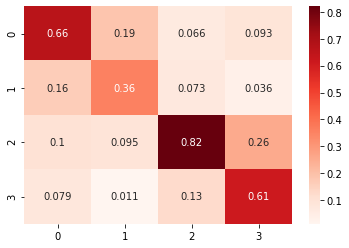

In [29]:
print_classification_report(df, MODEL_NAME)